In [1]:
from astropy.table import Table,vstack
import matplotlib.pyplot as plt
import numpy as np
import pickle
from copy import deepcopy
import sys,os,glob,math
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import WMAP9 as cosmo
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

In [2]:
def simple_cat_out(simple,outname):
    simple=deepcopy(simple)
    simple['DELAY2']=[','.join(x.astype(str)) for x in simple['DELAY']]
    simple.remove_column('DELAY')
    simple.rename_column('DELAY2','DELAY')
    simple['MAG2']=[','.join(x.astype(str)) for x in simple['MAG']]
    simple.remove_column('MAG')
    simple.rename_column('MAG2','MAG')
    simple['XIMG2']=[','.join(x.astype(str)) for x in simple['XIMG']]
    simple.remove_column('XIMG')
    simple.rename_column('XIMG2','XIMG')
    simple['YIMG2']=[','.join(x.astype(str)) for x in simple['YIMG']]
    simple.remove_column('YIMG')
    simple.rename_column('YIMG2','YIMG')
    simple.write(outname,format='ascii',overwrite=True)
def read_om_cat(filename,log):
    wfirst = Table.read(filename,format='ascii')
    colnames=['NIMG','ZLENS','SIGMA','ZSRC','MAGH','APMAG_H','IMSEP','EPSILON','PHI','KAPPA','THETA',
             'XSRC','YSRC','TYP','LENSID']
    for i in range(len(wfirst.colnames)):
        wfirst.rename_column(wfirst.colnames[i],colnames[i])
    with open(log,'r') as f:
        log=f.readlines()
    ximg=[]
    yimg=[]
    mag=[]
    delay=[]
    i=0
    while i<len(log)-2:
        nimg=int(log[i][0])
        rows=log[i+1:i+nimg+1]
        i+=(nimg+1)
        dat=[]
        for row in rows:
            row=row.split(' ')
            row=[x.strip('\n') for x in row]
            row=[float(x) for x in row if len(x)>0]
            dat.append(row)
        ximg.append(np.array([x[0] for x in dat]))
        yimg.append(np.array([x[1] for x in dat]))
        mag.append(np.array([x[2] for x in dat]))
        delay.append(np.array([x[3] for x in dat]))

    wfirst['XIMG']=ximg
    wfirst['YIMG']=yimg
    wfirst['MAG']=mag
    wfirst['DELAY']=delay
    wfirst['MAG']=np.array([-2.5*np.log10(np.abs(x)) for x in wfirst['MAG']])
    return(wfirst)

def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, 
					 scatter_alpha=.5,global_hist=False,kind='scatter',dist_kde=True,dist_hist=False,
					 replacements=None,xlim=None,ylim=None,bins_x=None,bins_y=None,**kwargs):
	import seaborn as sns

	def colored_scatter(x, y, c=None):
		def scatter(*args, **kwargs):
			args = (x, y)
			if c is not None:
				kwargs['c'] = c
			kwargs['alpha'] = scatter_alpha
			plt.scatter(*args, **kwargs)
			ax=plt.gca()

		return scatter
	g = sns.JointGrid(
		x=col_x,
		y=col_y,
		data=df,
		xlim=xlim,
		ylim=ylim
	)

	color = None
	legends=[]
	handles=[]
	for name, df_group in df.groupby(col_k):
		legends.append(str(name))
		if k_is_color:
			color=name
		if kind=='scatter':
			g.plot_joint(
				colored_scatter(df_group[col_x],df_group[col_y],c=color),
			)
		elif kind=='kde':
			g.x=df_group[col_x]
			g.y=df_group[col_y]
			handles.append(g.plot_joint(sns.kdeplot,label=str(name),**kwargs))
	
	for name, df_group in df.groupby(col_k):
		sns.distplot(
			df_group[col_x].values,
			ax=g.ax_marg_x,
			color=color,
			kde=dist_kde,
			hist=dist_hist,
			bins=bins_x
		)
		sns.distplot(
			df_group[col_y].values,
			ax=g.ax_marg_y,
			color=color,            
			vertical=True,
			kde=dist_kde,
			hist=dist_hist,
			bins=bins_y
		)
	# Do also global Hist:
	if global_hist:
		sns.distplot(
			df[col_x].values,
			ax=g.ax_marg_x,
			color='grey'
		)
		sns.distplot(
			df[col_y].values.ravel(),
			ax=g.ax_marg_y,
			color='grey',
			vertical=True
		)
	if replacements is not None:
		xlabel = g.ax_joint.get_xlabel()
		ylabel = g.ax_joint.get_ylabel()
		if xlabel in replacements.keys():
			g.ax_joint.set_xlabel(replacements[xlabel],fontsize=16)
		if ylabel in replacements.keys():
			g.ax_joint.set_ylabel(replacements[ylabel],fontsize=16)
		g.ax_joint.legend([x if x not in replacements.keys() else replacements[x] for x in legends])
	return(g)

In [3]:
###read Roman survey catalogs
folder="/Users/rodney/Dropbox/src/snRequiem/Analysis/Lensing"
files=glob.glob(os.path.join(folder,'*result.dat'))
oguri_cats=pickle.load(open('all_cats.pkl','rb'))
print(oguri_cats.keys())

dict_keys(['hls-deep', 'lowz_medium', 'lowz_shallow', 'ultradeep', 'lowz', 'allz', 'highz'])


In [9]:
###read LSST catalog
lsst=read_om_cat('LSST_Catalog/sne_mock_result.dat',
                 'LSST_Catalog/sne_mock_log.dat')

In [12]:
lsst[:3]

NIMG,ZLENS,SIGMA,ZSRC,MAGH,APMAG_H,IMSEP,EPSILON,PHI,KAPPA,THETA,XSRC,YSRC,TYP,LENSID,XIMG,YIMG,MAG,DELAY
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,object,object,object,object
4,0.076,221.8196,0.16,23.17,21.85035,1.666138,0.5159846,179.1233,0.03233433,-158.0094,-0.2457572,0.003997407,4,131322,[ 0.36 -1.0854 0.5753 0.3784],[-0.4141 -0.0296 0.1049 0.4322],[-1.31965452 -0.69739818 -2.36352373 -1.7120461 ],[7.108 0. 6.913 6.982]
2,0.118,238.7811,0.88,24.13,22.5081,2.591348,0.04262399,13.65931,0.03376388,-154.4095,-0.02452842,0.1425729,4,474132,[0.3119 0.4903],[-1.1559 1.4293],[-1.62189991 -2.87502495],[6.448 0. ]
4,0.126,179.8871,0.64,23.77,22.26762,1.368103,0.2744606,-4.892542,0.04922587,164.1205,-0.01130652,0.1223515,4,567207,[-0.0275 -0.6935 0.6716 0.2956],[-0.5395 0.5033 0.4127 0.7061],[-0.45453754 -1.50237781 -2.21690342 -2.22486415],[3.698 0. 0.76 0.853]


In [58]:
# define a function to compute the mass from the given properties
# Using the Auger+ 2010 relations between sigma and M* and M* to Mtot

def mass_stellar(sigma, a=0.18, da=0.03, b=2.34, db=0.01, 
                 logsigmascatter=0.04):
    """Linear fit relating log(sigma) (vel. disp.) to log(M*) (stellar mass)
    From Auger+ 2010 Table 2 and Fig 2 (left panel)"""

    logsigma = np.log10(sigma)
    logM = (logsigma - b)/a
    linfit_err = logM * np.sqrt( (db**2/(logsigma-b)**2) + (da**2/a**2))
    
    # intrinsic scatter in sigma, projected onto Mass
    logM_err_from_sigmascatter = logsigmascatter/a
    
    logM_err = np.sqrt(linfit_err**2 + logM_err_from_sigmascatter**2)
    
    return(logM, logM_err)


def mass_total(logmstar, a=0.80, da=0.04, b=0.36, db=0.05, 
               logmstarscatter=0.03):
    """Linear fit relating log(M*) (stellar mass) to log(M_re/2) (total mass)
    From Auger+ 2010 Table 3 and Fig 3 (middle panel)"""
    logMtot = (logmstar - b)/a
    linfit_err = logMtot * np.sqrt( (db**2/(logmstar-b)**2) + (da**2/a**2))
    
    # intrinsic scatter in M*, projected onto M_tot
    logMtot_err_from_mstarscatter = logmstarscatter/a
    
    logMtot_err = np.sqrt(linfit_err**2 + logMtot_err_from_mstarscatter**2)
    
    return(logMtot, logMtot_err)


# from OM10: 
# theta_ein = 4*np.pi*(sigma/c)**2 * Dls / Ds
def mass_total_from_sigma(sigma):
    logMstar, logMstar_err = mass_stellar(sigma)
    logMtot, logMtot_err = mass_total(logMstar)
    err = np.sqrt(logMtot_err**2 + logMstar_err**2)
    return(logMtot, err)

In [46]:
sigma = np.logspace(2.1, 2.6, 50)
logmstar, logmstar_err = mass_stellar(sigma)
logmtot, logmtot_err = mass_total(logmstar)

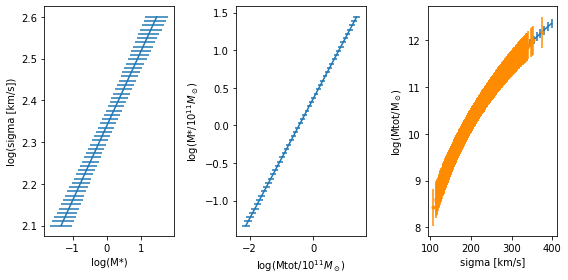

In [60]:
fig = plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.errorbar(logmstar, np.log10(sigmas), xerr=logmstar_err)
ax1.set_xlabel("log(M*)")
ax1.set_ylabel("log(sigma [km/s])")

ax2.errorbar(logmtot, logmstar, xerr=logmtot_err)
ax2.set_xlabel("log(Mtot/10$^{11} M_\odot$)")
ax2.set_ylabel("log(M*/10$^{11} M_\odot$)")


ax3.errorbar(sigma, logmtot+11, yerr=logmtot_err)
ax3.set_ylabel("log(Mtot/M$_\odot$)")
ax3.set_xlabel("sigma [km/s]")

lsst_sigma = lsst['SIGMA']
log_lsst_mass, log_lsst_mass_err = mass_total_from_sigma(lsst_sigma)

ax3.errorbar(lsst_sigma, log_lsst_mass+11, yerr=log_lsst_mass_err, 
             ls=' ', marker='.', color='darkorange' )

plt.tight_layout()

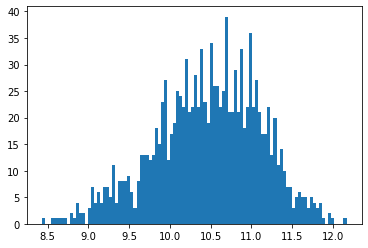

In [63]:
lsst_sigma = lsst['SIGMA']
log_lsst_mass, log_lsst_mass_err = mass_total_from_sigma(lsst_sigma)

histout = plt.hist(log_lsst_mass+11, bins=100)

In [67]:
maxdelay = np.array([np.max(d) for d in lsst['DELAY']])

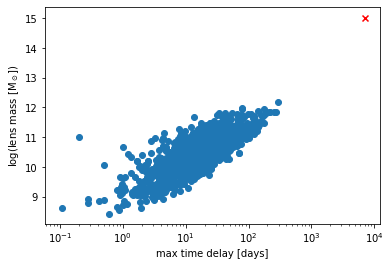

In [77]:
plt.scatter(maxdelay, log_lsst_mass+11)

plt.scatter([7000],[15], marker='x', color='r')
ax = plt.gca()
ax.set_xlabel('max time delay [days]')
ax.set_ylabel('log(lens mass [M$_\odot$])')
ax.set_xscale('log')
#ax.set_yscale('log')

In [ ]:
# TODO : collect the masses and redshifts of the frontier field galaxy clusters, the RELICS clusters, etc, and compare to the MRG0138 cluster

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-13-f708784a08b6>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('ngrst_vs_lsst_%s_%s.pdf'%(xvar,yvar),format='pdf',overwrite=True)


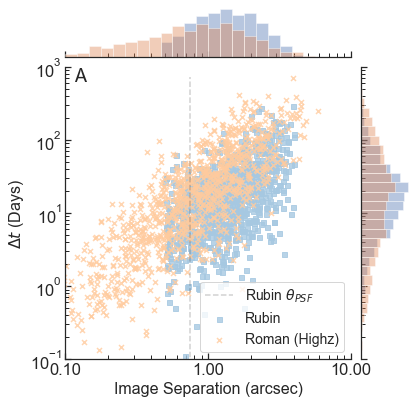

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-13-f708784a08b6>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('ngrst_vs_lsst_%s_%s.pdf'%(xvar,yvar),format='pdf',overwrite=True)


<Figure size 432x288 with 0 Axes>

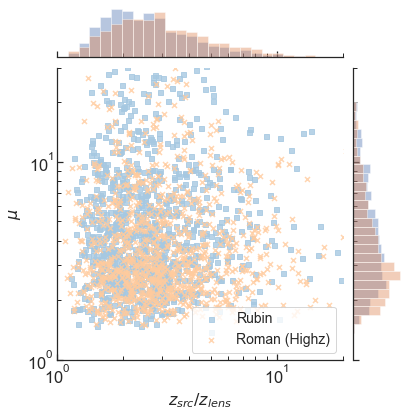

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-13-f708784a08b6>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('ngrst_vs_lsst_%s_%s.pdf'%(xvar,yvar),format='pdf',overwrite=True)


<Figure size 432x288 with 0 Axes>

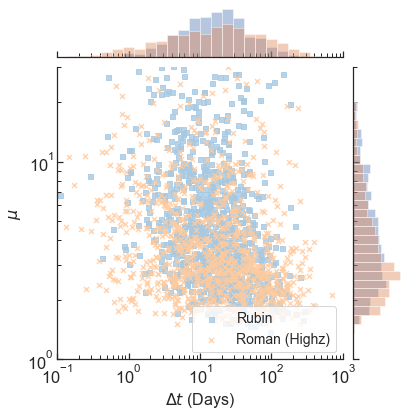

/Users/jpierel/miniconda3/envs/basic/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-13-f708784a08b6>:94: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('ngrst_vs_lsst_%s_%s.pdf'%(xvar,yvar),format='pdf',overwrite=True)


<Figure size 432x288 with 0 Axes>

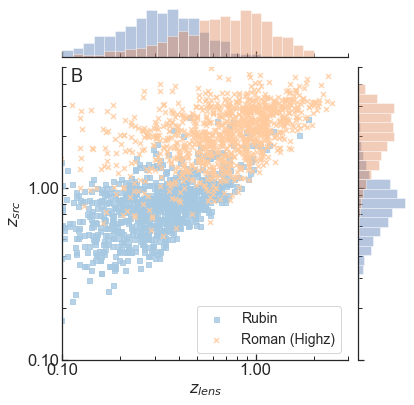

<Figure size 432x288 with 0 Axes>

In [13]:
###LSST Roman Comparison

cat_name='highz'
colors={'allz':'k','ultradeep':'r','highz':'purple','highz-slow':'b',
        'lowz':'g'}#'hls-cal':'g','hls-deep':'brown'}

np.random.seed(5) # since I do random pulls of 1000 from each catalog
all_cat=None # seaborn wants a single dataframe for this type of plotting
cat=oguri_cats[cat_name]
cat['SURVEY']=cat_name
randoms_w=np.random.choice(len(cat),size=1000,replace=False)
randoms_l=np.random.choice(len(lsst),size=1000,replace=False)
if all_cat is None:
    all_cat=cat[randoms_w]
else:
    all_cat=vstack([all_cat,cat[randoms_w]])
        
        
lsst['SURVEY']='Rubin' # for legend
all_cat=vstack([all_cat,lsst[randoms_l]])
all_cat['RATIO']=all_cat['ZSRC']/all_cat['ZLENS']

all_cat['DELAY']=[np.max(np.abs(x)) for x in all_cat['DELAY']]
all_cat['MAG']=[np.max(10**(-.4*x)) for x in all_cat['MAG']]
lims={'IMSEP':(.1,10),'DELAY':(.1,1000),
     'RATIO':(1,20),'MAG':(1,30),'ZSRC':(.1,5),'ZLENS':(.1,3)}
bins={'IMSEP':(.1,10),'DELAY':(.1,500),
     'RATIO':(1,15),'MAG':(1,20),'ZSRC':(.1,4),'ZLENS':(.1,2)}
tickFormats={'IMSEP':False,'ZSRC':False,'ZLENS':False}

sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_style('ticks')
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
for params in [['IMSEP','DELAY'],['RATIO','MAG'],['DELAY','MAG'],['ZLENS','ZSRC']]: # the plots to make
    xvar=params[0]
    yvar=params[1]
    
    ax1=multivariateGrid(xvar,yvar,'SURVEY',all_cat.to_pandas(),dist_hist=True,
                                     dist_kde=False,
                                    scatter_alpha=0,bins_y=np.logspace(np.log10(bins[yvar][0]),
                                                                       np.log10(bins[yvar][1]), 30),
                                     bins_x=np.logspace(np.log10(bins[xvar][0]),
                                                        np.log10(bins[xvar][1]), 25),
                                                         density=True,
                                     replacements={'IMSEP':'Image Separation (arcsec)',
                                                   'DELAY':r'$\Delta t$'+' (Days)',
                                                   'RATIO':r'$z_{src}/z_{lens}$',
                                                   'MAG':r'$\mu$',
                                                   'ZSRC':'$z_{src}$',
                                                   'ZLENS':'$z_{lens}$'}
                                    )
    lsst_inds=np.where(all_cat['SURVEY']=='Rubin')[0]
    wfirst_inds=np.where(all_cat['SURVEY']==cat_name)[0]
    quad_inds_lsst=[i for i in lsst_inds if all_cat[i]['NIMG']==4]
    quad_inds_wfirst=[i for i in wfirst_inds if all_cat[i]['NIMG']==4]
    double_inds_lsst=[i for i in lsst_inds if all_cat[i]['NIMG']==2]
    double_inds_wfirst=[i for i in wfirst_inds if all_cat[i]['NIMG']==2]
    
    ax1.x=all_cat[lsst_inds][xvar]
    ax1.y=all_cat[lsst_inds][yvar]
    ax1.plot_joint(plt.scatter, marker='s', c='#a6c8e1', s=25,alpha=.8,label='Rubin')
    if xvar=='IMSEP': # just for that dashed line
        ylim=plt.ylim()
        ax1.x=[.75,.75]
        ax1.y=ylim
        ax1.plot_joint(plt.plot,color='k',linestyle='--',alpha=.2,
                     label='Rubin '+r'$\theta_{PSF}$')

    ax1.x=all_cat[wfirst_inds][xvar]
    ax1.y=all_cat[wfirst_inds][yvar]
    ax1.plot_joint(plt.scatter, marker='x', c='#ffcb9e', s=25,alpha=.8,label='Roman (Highz)')

    if xvar=='IMSEP':
        ax1.ax_joint.annotate('A',(.03,.95),xycoords='axes fraction',fontsize=18)
    elif xvar=='ZLENS':
        ax1.ax_joint.annotate('B',(.03,.95),xycoords='axes fraction',fontsize=18)
    ax1.ax_joint.legend(fontsize=14,loc='lower right')
    
    plt.yscale('log')
    plt.xscale('log')
    if xvar in tickFormats.keys():
        formatter=ScalarFormatter()
        formatter.set_scientific(tickFormats[xvar])
        ax1.ax_joint.xaxis.set_major_formatter(formatter)
    if yvar in tickFormats.keys():
        formatter=ScalarFormatter()
        formatter.set_scientific(tickFormats[yvar])
        ax1.ax_joint.yaxis.set_major_formatter(formatter)

    plt.ylim(lims[yvar])
    plt.xlim(lims[xvar])

    plt.savefig('ngrst_vs_lsst_%s_%s.pdf'%(xvar,yvar),format='pdf',overwrite=True)
    plt.show()
    plt.clf()
